<a href="https://colab.research.google.com/github/NanThawe/ML-DL-projects/blob/main/MCQ_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MCQ scanner**

##Import Modules

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from imutils.perspective import four_point_transform
import imutils

In [21]:
def show_images(titles, images, wait=True):
    """Display multiple images with one line of code"""

    for (title, image) in zip(titles, images):
        plt.title(title)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

    if wait:
        cv2.waitKey(0)
        cv2.destroyAllWindows()

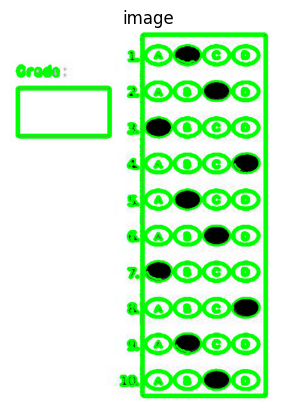

In [22]:
height = 800
width = 600
green = (0, 255, 0) # green color
red = (0, 0, 255) # red color
white = (255, 255, 255) # white color
questions = 10
answers = 4
#correct_ans = [0, 2, 0, 3, 3]
correct_ans = [1, 2, 3, 3, 0, 2, 0, 2, 1, 2]

img = cv2.imread('/content/org.jpeg')
img = cv2.resize(img, (width, height))
img_copy = img.copy() # for display purposes
img_copy1 = img.copy() # for display purposes
img_copy2 = img.copy() # for display purposes

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
edge_img = cv2.Canny(blur_img, 75, 200) # adjust with your images

# find the contours in the image
contours, _ = cv2.findContours(edge_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# draw the contours
cv2.drawContours(img, contours, -1, green, 3)
show_images(['image'], [img]) # helper function in helper.py file

In [23]:
def get_rect_cnts(contours):
    rect_cnts = []
    for cnt in contours:
        # approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        # if the approximated contour is a rectangle ...
        if len(approx) == 4:
            # append it to our list
            rect_cnts.append(approx)
    # sort the contours from biggest to smallest
    rect_cnts = sorted(rect_cnts, key=cv2.contourArea, reverse=True)

    return rect_cnts

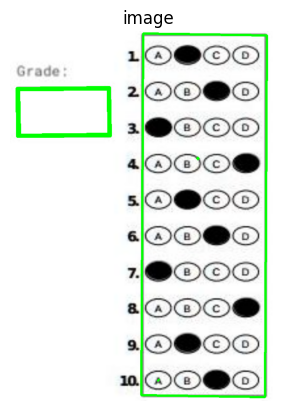

In [24]:
rect_cnts = get_rect_cnts(contours)
# warp perspective to get the top-down view of the document
# document = four_point_transform(img_copy, rect_cnts[0].reshape(4, 2))
# doc_copy = document.copy()  # for display purposes
# doc_copy1 = document.copy() # for display purposes

cv2.drawContours(img_copy, rect_cnts, -1, green, 3)
# helper function in helper.py file
show_images(['image'], [img_copy])

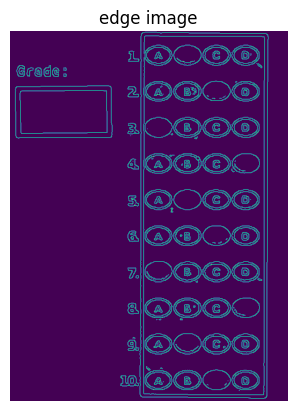

[array([[[286,   3]],

       [[280, 785]],

       [[548, 794]],

       [[556,   8]]], dtype=int32), array([[[217, 120]],

       [[ 14, 120]],

       [[ 13, 229]],

       [[218, 229]]], dtype=int32), array([[[26, 85]],

       [[25, 85]],

       [[23, 87]],

       [[23, 88]]], dtype=int32)]


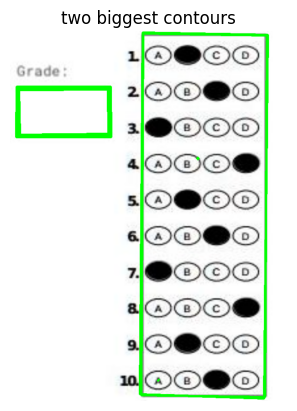

In [25]:
########################################################################
# Find the Two Biggest Contours on the Document
########################################################################

# find contours on the document
gray_doc = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
blur_doc = cv2.GaussianBlur(gray_doc, (3, 3), 0)
edge_doc = cv2.Canny(blur_doc, 10, 70)
show_images(['edge image'], [edge_doc])
contours, _ = cv2.findContours(edge_doc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rect_cnts = get_rect_cnts(contours)
print(rect_cnts)
# contours of the questions
biggest_cnt = rect_cnts[0]
# contours of the grade
grade_cnt = rect_cnts[1]

# draw the two biggest contours, which are the
# contour of the questions and the contour of the grade
cv2.drawContours(img_copy, rect_cnts[:2], -1, green, 3)
show_images(['two biggest contours'], [img_copy])

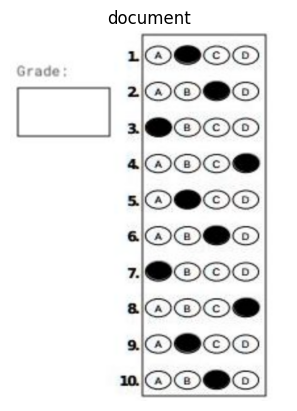

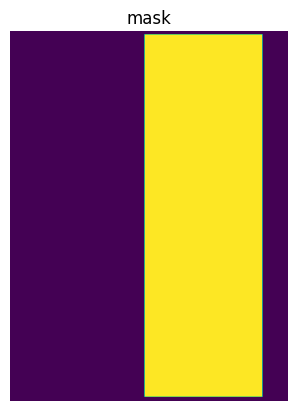

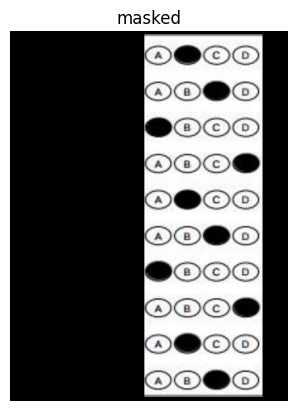

[[[140 140 140]
  [138 138 138]
  [135 135 135]
  ...
  [136 136 136]
  [136 136 136]
  [136 136 136]]

 [[140 140 140]
  [139 139 139]
  [137 137 137]
  ...
  [137 137 137]
  [137 137 137]
  [137 137 137]]

 [[140 140 140]
  [140 140 140]
  [140 140 140]
  ...
  [137 137 137]
  [137 137 137]
  [139 139 139]]

 ...

 [[144 145 143]
  [144 145 143]
  [145 146 144]
  ...
  [148 148 148]
  [147 147 147]
  [145 145 145]]

 [[136 137 135]
  [137 138 137]
  [139 140 138]
  ...
  [140 140 140]
  [140 140 140]
  [139 139 139]]

 [[135 135 134]
  [137 138 137]
  [140 140 140]
  ...
  [138 138 138]
  [139 139 139]
  [140 140 140]]]


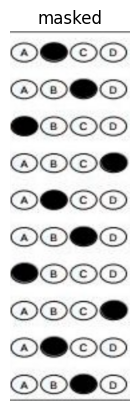

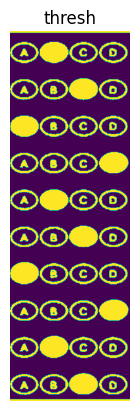

In [26]:
########################################################################
# Mask Everything in the Document Except the Area of the Biggest Contour
########################################################################

# cooredinates of the biggest contour
# I added 4 pixels to x and y, and removed 4 pixels from x_W and y_H to make
# sure we are inside the contour and not take the border of the biggest contour
x, y = biggest_cnt[0][0][0] + 4, biggest_cnt[0][0][1] + 4
x_W, y_H = biggest_cnt[2][0][0] - 4, biggest_cnt[2][0][1] - 4

# create a black image with the same dimension as the document
mask =  np.zeros((img_copy.shape[0], img_copy.shape[1]), np.uint8)
# we create a white rectangle in the region of the biggest contour
cv2.rectangle(mask, (x, y), (x_W, y_H), white, -1)
masked = cv2.bitwise_and(img_copy1, img_copy1, mask=mask)

show_images(['document', 'mask', 'masked'], [img_copy1, mask, masked])

# take only the region of the biggest contour
masked = masked[y:y_H, x:x_W]
print(masked)
gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

show_images(['masked', 'thresh'], [masked, thresh])

In [27]:
########################################################################
# Split the Area of the Biggest Contour
########################################################################

# split the thresholded image into boxes
def split_image(image):
    # make the number of rows and columns
    # a multiple of 5 (questions = answers = 5)
    r = len(image) // questions * questions
    c = len(image[0]) // answers * answers
    image = image[:r, :c]
    # split the image horizontally (row-wise)
    rows = np.vsplit(image, questions)
    boxes = []
    for row in rows:
        # split each row vertically (column-wise)
        cols = np.hsplit(row, answers)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = split_image(thresh)


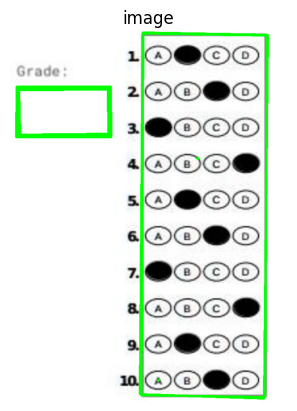

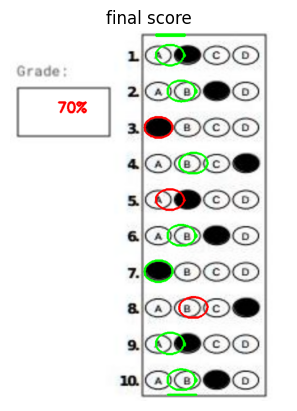

In [28]:
########################################################################
# Start Grading the Document
########################################################################

score = 0

# loop over the questions
for i in range(0, questions):
    user_answer = None

    # loop over the answers
    for j in range(answers):
        pixels = cv2.countNonZero(boxes[j + i * 4])
        # if the current answer has a larger number of
        # non-zero (white) pixels then the previous one
        # we update the `user_answer` variable
        if user_answer is None or pixels > user_answer[1]:
            user_answer = (j, pixels)

    # find the contours of the bubble that the user has filled
    cnt, _ = cv2.findContours(boxes[user_answer[0] + i * 4],
                                      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # translate the coordinates of the contours
    # to their original place in the document
    for c in cnt:
        c[:, :, 0] += x + ((x_W - x) // 10) * user_answer[0]
        c[:, :, 1] += y + ((y_H - y) // 10) * i


    # if the user's answer is correct, we increase the score and draw
    # a green contour arround the bubble that the user has filled
    if correct_ans[i] == user_answer[0]:
        cv2.drawContours(img_copy2, cnt, -1, [0,255,0], 3)
        score += 1
    # otherwise we draw a red contour
    else:
        cv2.drawContours(img_copy2, cnt, -1, [255,0,0], 3)

score = (score / 10) * 100

# get the (x, y) coordinates of the grade contour.
# we add some pixels to make sure the text is inside the contour.
x_grade = grade_cnt[0][0][0] + -115
y_grade = grade_cnt[0][0][1] + 55
cv2.putText(img_copy2, "{}%".format(int(score)),
            (x_grade, y_grade), cv2.FONT_HERSHEY_SIMPLEX, 1, [255,0,0], 3)

show_images(['image', 'final score'], [img_copy, img_copy2])